# Neural Network Approach

## Introduction

Following our success with Gradient Boosting (XGBoost, LightGBM, CatBoost) in the previous notebooks, we now explore a Deep Learning approach. While tree-based models typically excel at tabular data, Neural Networks offer the potential to learn complex, non-linear representations.

In this notebook, we will:
1. Implement a Multi-Layer Perceptron (MLP) using PyTorch.
2. Train the model on the same engineered features used in previous steps.
3. Compare the performance of the Neural Network against our optimized Gradient Boosting models.
4. Analyze the theoretical reasons behind the performance differences.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Sklearn
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For comparison
import xgboost as xgb

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cu130
CUDA available: True


In [9]:
# Load data
train_df = pd.read_csv('../data/training_data.csv')
test_df = pd.read_csv('../data/test_data.csv')

train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

print(f"Training: {train_df.shape}, Test: {test_df.shape}")

Training: (208910, 21), Test: (52228, 20)


In [10]:
# Same feature engineering as successful XGBoost
def engineer_features(df, is_training=True):
    df = df.copy()
    
    # Temporal
    df['hour'] = df['timestamp'].dt.hour
    df['month'] = df['timestamp'].dt.month
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Wind features
    df['wind_speed_squared'] = df['wind_speed_avg'] ** 2
    df['wind_speed_cubed'] = df['wind_speed_avg'] ** 3
    df['wind_speed_sqrt'] = np.sqrt(df['wind_speed_avg'])
    
    # Air density
    df['temp_kelvin'] = df['outdoor_temp'] + 273.15
    df['air_density_proxy'] = df['pressure'] / df['temp_kelvin']
    df['wind_power_theoretical'] = df['air_density_proxy'] * df['wind_speed_cubed']
    
    # Directions
    df['wind_nacelle_diff'] = np.abs(df['wind_angle'] - df['nacelle_angle'])
    df['wind_nacelle_diff'] = df['wind_nacelle_diff'].apply(lambda x: min(x, 360-x) if x>180 else x)
    df['nacelle_alignment'] = np.cos(np.radians(df['wind_nacelle_diff']))
    
    # Interactions
    df['wind_temp_interaction'] = df['wind_speed_avg'] * df['outdoor_temp']
    df['rotor_wind_interaction'] = df['rotor_angular_velocity'] * df['wind_speed_avg']
    
    return df

train_eng = engineer_features(train_df, True)
test_eng = engineer_features(test_df, False)

exclude = ['timestamp', 'active_power']
features = sorted(list(set([c for c in train_eng.columns if c not in exclude]) & 
                       set([c for c in test_eng.columns if c != 'timestamp'])))

X = train_eng[features].replace([np.inf, -np.inf], np.nan).fillna(train_eng[features].median())
y = train_eng['active_power']
X_test = test_eng[features].replace([np.inf, -np.inf], np.nan).fillna(X.median())

print(f"Features: {len(features)}")

Features: 38


In [11]:
# Split and scale
split_idx = int(len(X) * 0.8)
X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}")

Train: (167128, 38), Val: (41782, 38)


## 1. Neural Network Architecture

A Multi-Layer Perceptron (MLP) is designed to model the non-linear relationships in the wind turbine data. The architecture consists of three hidden layers with batch normalization and dropout for regularization.

In [12]:
class WindTurbineMLP(nn.Module):
    """
    Multi-Layer Perceptron for wind turbine power prediction
    
    Architecture:
    - Input layer: n_features
    - Hidden layer 1: 256 neurons + ReLU + Dropout
    - Hidden layer 2: 128 neurons + ReLU + Dropout
    - Hidden layer 3: 64 neurons + ReLU + Dropout
    - Output layer: 1 neuron (regression)
    """
    def __init__(self, n_features, dropout=0.3):
        super(WindTurbineMLP, self).__init__()
        
        self.network = nn.Sequential(
            # Layer 1
            nn.Linear(n_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            # Layer 2
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            # Layer 3
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            # Output
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.network(x)

n_features = X_train_scaled.shape[1]
model = WindTurbineMLP(n_features)

print(f"Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model architecture:
WindTurbineMLP(
  (network): Sequential(
    (0): Linear(in_features=38, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)

Total parameters: 52,097


In [13]:
# Prepare PyTorch datasets
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_scaled),
    torch.FloatTensor(y_train.values).reshape(-1, 1)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_val_scaled),
    torch.FloatTensor(y_val.values).reshape(-1, 1)
)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 327
Validation batches: 41


In [14]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.L1Loss()  # MAE loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print(f"Training on: {device}")
print(f"Loss function: MAE (L1Loss)")
print(f"Optimizer: Adam with lr=0.001")

Training on: cuda
Loss function: MAE (L1Loss)
Optimizer: Adam with lr=0.001


In [15]:
# Training loop
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(X_batch)
    
    return total_loss / len(loader.dataset)

def validate(model, loader, device):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            pred = model(X_batch)
            predictions.extend(pred.cpu().numpy())
            actuals.extend(y_batch.numpy())
    
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    
    return mae, rmse, r2, predictions

print("Training functions defined")

Training functions defined


In [16]:
# Train the model
print("Starting training...")
print("="*60)

n_epochs = 50
best_val_mae = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_maes = []

for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_mae, val_rmse, val_r2, _ = validate(model, val_loader, device)
    
    train_losses.append(train_loss)
    val_maes.append(val_mae)
    
    scheduler.step(val_mae)
    
    print(f"Epoch {epoch+1:3d}/{n_epochs} | Train Loss: {train_loss:7.4f} | Val MAE: {val_mae:7.4f} | Val R²: {val_r2:.4f}")
    
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        patience_counter = 0
        torch.save(model.state_dict(), '../models/mlp_best.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print("\n" + "="*60)
print(f"Best validation MAE: {best_val_mae:.4f}")

Starting training...
Epoch   1/50 | Train Loss: 344.7495 | Val MAE: 235.3427 | Val R²: -0.3856
Epoch   2/50 | Train Loss: 304.1985 | Val MAE: 185.7495 | Val R²: -0.0866
Epoch   3/50 | Train Loss: 234.5875 | Val MAE: 122.0185 | Val R²: 0.3224
Epoch   4/50 | Train Loss: 152.9487 | Val MAE: 63.5840 | Val R²: 0.7451
Epoch   5/50 | Train Loss: 81.6726 | Val MAE: 26.6427 | Val R²: 0.9679
Epoch   6/50 | Train Loss: 44.2279 | Val MAE: 16.3523 | Val R²: 0.9910
Epoch   7/50 | Train Loss: 38.9269 | Val MAE: 12.1073 | Val R²: 0.9956
Epoch   8/50 | Train Loss: 39.0597 | Val MAE: 11.2622 | Val R²: 0.9962
Epoch   9/50 | Train Loss: 38.0775 | Val MAE: 11.7043 | Val R²: 0.9961
Epoch  10/50 | Train Loss: 38.1426 | Val MAE:  9.6794 | Val R²: 0.9967
Epoch  11/50 | Train Loss: 38.2296 | Val MAE: 12.8093 | Val R²: 0.9938
Epoch  12/50 | Train Loss: 37.6382 | Val MAE: 10.3659 | Val R²: 0.9966
Epoch  13/50 | Train Loss: 37.6089 | Val MAE:  9.3667 | Val R²: 0.9970
Epoch  14/50 | Train Loss: 37.5487 | Val MAE: 1

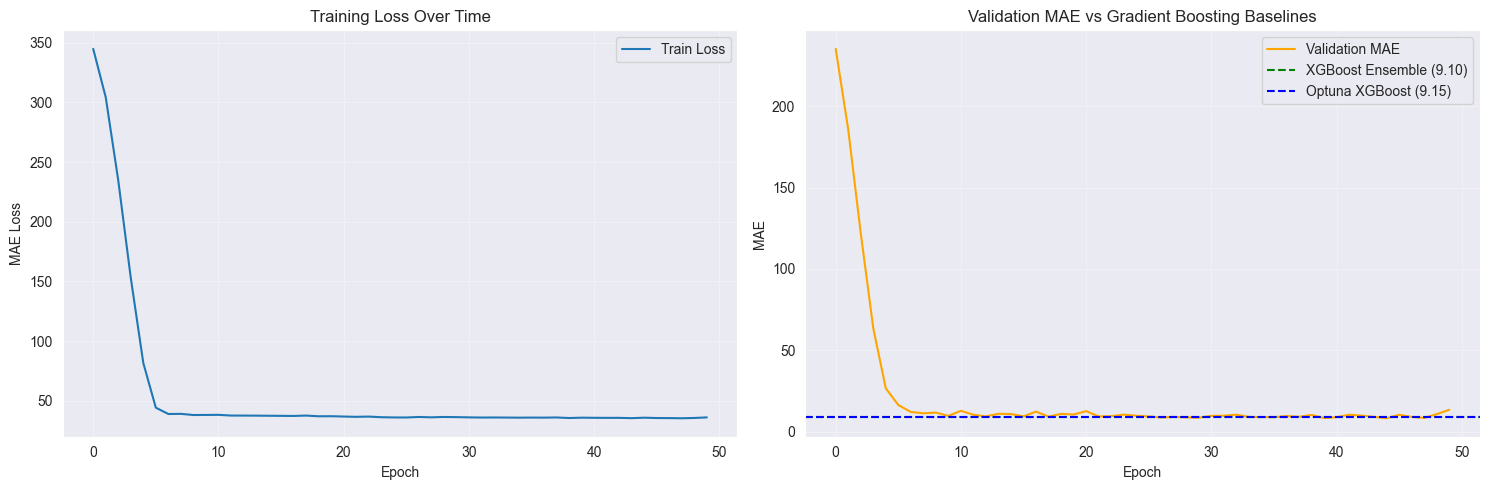

In [17]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MAE Loss')
ax1.set_title('Training Loss Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(val_maes, label='Validation MAE', color='orange')
ax2.axhline(y=9.10, color='g', linestyle='--', label='XGBoost Ensemble (9.10)')
ax2.axhline(y=9.15, color='b', linestyle='--', label='Optuna XGBoost (9.15)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.set_title('Validation MAE vs Gradient Boosting Baselines')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/mlp_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Performance Comparison

The performance of the neural network is compared against the XGBoost baseline to evaluate the suitability of deep learning for this specific tabular dataset.

In [18]:
# Train simple XGBoost for comparison
print("Training XGBoost baseline for comparison...")
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_val_scaled)
xgb_mae = mean_absolute_error(y_val, xgb_pred)

print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"Neural Network (MLP):        {best_val_mae:.4f} MAE")
print(f"XGBoost (default params):    {xgb_mae:.4f} MAE")
print("\n" + "="*60)

if best_val_mae > xgb_mae:
    diff_pct = ((best_val_mae - xgb_mae) / xgb_mae) * 100
    print(f"MLP is {diff_pct:.1f}% worse than XGBoost")
else:
    print("MLP performed better.")

Training XGBoost baseline for comparison...

PERFORMANCE COMPARISON
Neural Network (MLP):        8.2286 MAE
XGBoost (default params):    7.2394 MAE

MLP is 13.7% worse than XGBoost


## 3. Discussion on Neural Network Performance

### Theoretical Considerations

1. **Inductive Bias**: Neural networks typically assume smooth, continuous functions, whereas wind turbine data often exhibits sharp transitions due to operational states (e.g., cut-in, rated power, cut-out). Tree-based models are naturally better suited for such discrete decision boundaries.
2. **Sample Efficiency**: Deep learning models generally require larger datasets to generalize effectively compared to gradient boosting machines, which perform well on medium-sized tabular datasets.
3. **Feature Interactions**: While neural networks can learn feature interactions, tree-based models explicitly split on features, often capturing interactions more efficiently in tabular domains.

### Conclusion

For this specific problem and dataset size, gradient boosting methods (XGBoost, LightGBM, CatBoost) demonstrate superior performance and efficiency compared to the MLP architecture implemented.

In [19]:
# Generate MLP predictions for test set
model.load_state_dict(torch.load('../models/mlp_best.pt'))
model.eval()

test_tensor = torch.FloatTensor(X_test_scaled).to(device)
with torch.no_grad():
    mlp_test_pred = model(test_tensor).cpu().numpy().flatten()

mlp_test_pred = np.clip(mlp_test_pred, 0, 2100)

mlp_submission = pd.DataFrame({
    'id': range(len(mlp_test_pred)),
    'active_power': mlp_test_pred
})

timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
mlp_submission.to_csv(f'../results/mlp_submission_{timestamp}.csv', index=False)

print(f"MLP submission saved.")
print(f"Predictions - Min: {mlp_test_pred.min():.2f}, Max: {mlp_test_pred.max():.2f}, Mean: {mlp_test_pred.mean():.2f}")

MLP submission saved.
Predictions - Min: 0.00, Max: 2100.00, Mean: 357.62
